<a href="https://colab.research.google.com/github/nicolez9911/colab/blob/main/AdvML_L3S1_N1_Interpretability_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07_EX_01 Interpretability


The focus of this notebook is the concept of interpretability.

Interpretability and Explanability:

* Interpretability in the case of Machine Learning means that we are able to understand what the dimensions of the weight vectors mean. More generally that we are able to somehow interpret what the individual elements of the machine learning model mean.
* Explainability is a much higher goal. It means that we are able to understand and explain why a machine learning model has taken a decision.

Interpretability is a hot research topic in Machine Learning.
The reason it has become a central interest in ML research is the observation that for many real world use cases it is not sufficient to just measure accuracy of models. You also have to be able to understand what is happening in your model. You have to be able to get an idea what the model has learnt.

If we are able to interprete a machine learning model, that is if we can understand what is the meaning of:

* the parameters that are learnt
* the state of all the parameters in a learning phase
* the state of the parameters after learning

we have a chance to understand what is happening in our machine learning project.



## 1. Perceptron class

We will re-use the Perceptron class from `04_EX_01`.

The class is capable of doing binary classification and provides of the following methods:

* fit: train the Perceptron
* net_input: calculate the net_input
* predict: make a prediction based on a sample input

We have done one major change in this class compared to the version you have utilized so far.
Instead of calculating the dot product manually in Python we have delegated that to the `numpy.dot` method.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os


import numpy.random
from matplotlib._cm_listed import cmaps

class Perceptron(object):

    """Perceptron binary classifier.

    Parameters
    -----------
    eta : float
       Learning rate (value between 0.0 and 1.0)
    epochs  : int
       Number of passes over the training set

    Attributes
    -----------
    w_  : 1d-array
       Weights after fitting.
    errors_   : list
       Number of updates (triggered by prediction != target)

    """

    def __init__(self, eta=0.01, epochs=10, random_state=1):
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state

    def fit(self, X, y, draw, heatmap):
        """ Fit training data; i.e. train the Perceptron

        Parameters
        -----------
        X : dataframe with shape - [n_samples, n_features]
          feature vectors, where n_samples is the number of samples
          in the data set, n_features is the number of features
        y : dataframe with shape = [n_samples].
            1 target value per sample (the label).

        Returns
        -----------
        self : object

        """

        # this initialize the weights
        rgen = numpy.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])

        # this will be used to store the number of updates per epoch
        self.errors_ = []

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = target - self.predict(xi)
                if (error != 0):
                    update = self.eta * (error)
                    self.w_[1:] += update * xi
                    self.w_[0] += update
                    errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, x):
        """Calculate net input"""
        net_input = np.dot(x, self.w_[1:]) + self.w_[0]
        return net_input

    def predict(self, x):
        """Predict based on computing the net input and the threshold function"""
        net_input = self.net_input(x)
        if net_input >= 0.0:
            prediction = 1
        elif net_input < 0.0:
            prediction = -1
        return prediction

# Training Material

### MNIST Dataset

In order to start testing our Perceptron implementation we will move to a different and more realistially sized MNIST dataset.

We have already used the MNNIST dataset in the last semester when we started to familiarize us with the Machine Learning workflow.

"MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image." (source: http://yann.lecun.com/exdb/mnist/)

To save you some time the following cell contains code to download and sort the dataset.

In [5]:
# Download and sort the dataset

# Sorts the dataset by target (i.e the numbers 0-9). Sorts only the first 60000 entries (the training set).
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


# Download and sort the dataset
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]


print(mnist.target.shape)
print(mnist.data.shape)


(70000,)
(70000, 784)


## Creating a Binary Training Set


**Note**: Since the implementation of our Perceptron is binary it only will correctly work if we use the target values `-1` and `1`. That means you have to map `0` and `9` to `-1` and `1` in the training data.

In [6]:
from sklearn.utils import shuffle


# Select 5000 values for 0 and 9 each by manually checking the boundaries or by checking for target value.
mnist_0_target = mnist.target[0:5000]
mnist_0_data = mnist.data[0:5000]
mnist_9_target = mnist.target[6000:11000]
mnist_9_data = mnist.data[6000:11000]
mnist_bin_0_9_data = np.concatenate((mnist_0_data, mnist_9_data))
mnist_bin_0_9_target = np.concatenate((mnist_0_target, mnist_9_target))
mnist_bin_0_9_target = np.where(mnist_bin_0_9_target == 0, -1, 1)

# Shuffle should be something that the students have to identify as an element that impacts the learning
X, y = shuffle(mnist_bin_0_9_data, mnist_bin_0_9_target)
X = mnist_bin_0_9_data
y = mnist_bin_0_9_target
len(mnist_bin_0_9_data)

10000

# Heatmap Visualization

The method below expects a numpy array filled with double values as input and creates a 1D heatmap as output.




In [7]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 18,4

def heatmap_weight_vector(weight_vector, redraw=False):
    x = np.array(range(0,len(weight_vector) -1))
    y = weight_vector[1:]

    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

    ax.imshow(y[np.newaxis,:], cmap="RdBu", aspect="auto")
    ax2.plot(x,y)

    plt.tight_layout()
    plt.show()
    sleep(0.1)
    if redraw:
        clear_output(wait=True)



### Exercise 1

Test the output of the heatmap visualisaton method with a low-dimensional sample vector you create
Use the method `np.array` to wrap a list or an array into a numpy array. Your output should look similar as shown below.

### Exercise 2

Think about how we could integrate the visualization into the Perceptron training process in a way that would allow us to observe the training progress on the weight vector.

Once you have identified a suitable place, adapt the implementation of the Perceptron to include the heatmap visualisation.

Train a perceptron with the heatmap visualisation.

Your output should look similar to what can be seen below.

Training Finished


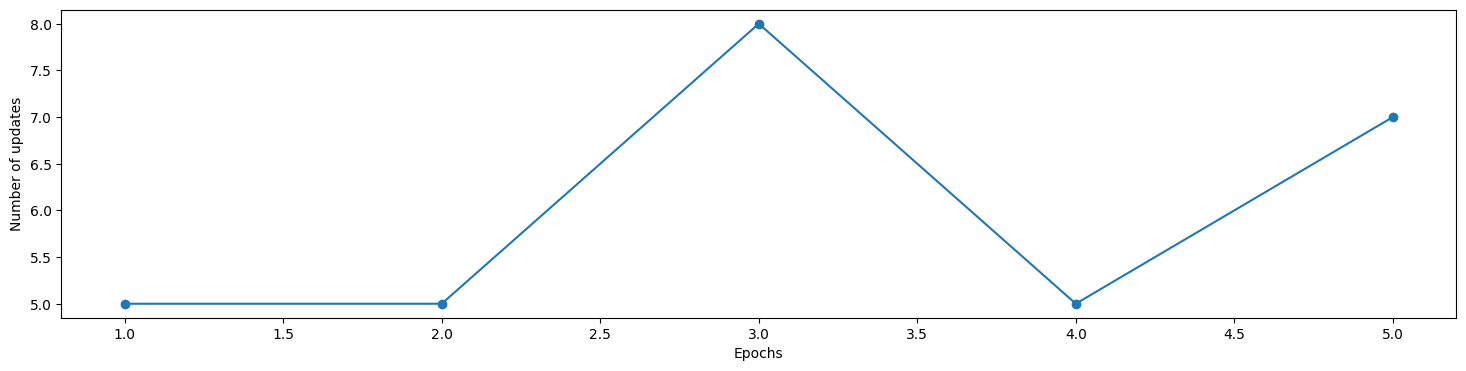

In [9]:
ppn = Perceptron(eta=0.1, epochs=5)
ppn.fit(X,y, False, True)
print('Training Finished')

# Plot number of epochs versus number of updates (i.e. errors, false classifications).
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()
